# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [56]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE4750/Homeworks/hw5-sigma-s-floating`


In [57]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

The objective of the function is to minimize cost. In order to so we must sum the transportation cost, fixed faciility cost, tipping cost, and recycling cost. Recyclying cost is only applicable to MRF and residual waste is ony a concern with MRF and WTE. When considering tipping cost you must consider both original waste and residual waste. Constraints you must consider are capacity of each facility and mass balance of both residual and original waste. The decision variables are operation of facilities, waste distribution to each facility, and residual waste distribution. 

As far as vizualizing the description above here is how the cost equations look like:

Landfill cost:
Capital Cost multiplied by binary indicator + tipping cost by waste:
$\\ \$2000 * Y1 + 50 * (W_{11} + W_{21} + W{31} + R_{2,}+ R_{31})$

MRF Cost: 
Capital Cost multiplied by binary indicator + tipping cost by waste + recycling cost:
$\\ \$1500 * Y2 + 7 * (W_{12} + W_{22} + W{32}) + 0.4* 40*(W_{12} + W_{22} + W_{32}) $

WTE Cost: 
Capital Cost multiplied by binary indicator + tipping cost by waste:
$\\ \$2500 * Y3 + 60 * (W_{13} + W_{23} + W{33}+ R{23}) $

Transportation Cost: Cost per Mg-km muliplied by distances and appropriate waste:
$ \$1.5 * [5 * W_{11} + 30 * W_{12} + 15 * W_{13} + 15 * W_{21} + 25 * W_{22} + 10 * W_{23} + 13 * W_{31} + 45 * W_{32} + 20 * W_{33} + 32 * R_{21} + 18 * W_{31} + 15 * W_{23}]$

Total Cost:
Sum of all facilities cost+ transportation cost

Here is vizualization of capacity equations:

Facility Capacity Constraints:
 $\\ W_{11} + W_{21} + W_{31} + R_{21} + R_{31} <= 200\$ $ 
 $\\ W_{12} + W_{22} + W_{32} <= 350\$ $
 $ \\ W_{13} + W_{23} + W_{33} + R_{23} <= 210\$ $

Waste Generation Constraints
$\\ W_{11} + W_{12} + W_{13} = 100\$ $
$\\ W_{21} + W_{22} + W_{23} = 90\$ $
$\\ W_{31} + W_{32} + W_{33} = 120\$ $


In [58]:
using JuMP, HiGHS


I = 1:3  # Cities
J = 1:3  # Facilities (LF, MRF, WTE)
K = 1:3  # Facilities for residual flows


production = [100, 90, 120]  # Waste produced by cities (Mg/day)
disposal_limit = [200, 350, 210]  # Facility capacities (Mg/day)
fixed_costs = [2000, 1500, 2500]  # Fixed costs of facilities ($/day)
tipping_costs = [50, 7, 60]  # Tipping costs ($/Mg)
MRF_recycling_rate = 0.4
MRF_recycling_cost = 40  # Recycling cost ($/Mg recycled)
WTE_residual_ash = 0.16
ash_recycled = 0.14


distances = [5 30 15; 15 25 10; 13 45 20]  # City to facility distances (km)
residual_distances = [0 32 18; 32 0 15; 18 15 0]  # Facility to facility distances (km)
transport_costs = 1.5 .* distances  # Transport costs for city to facility ($/Mg-km)
residual_costs = 1.5 .* residual_distances  # Transport costs for residual waste ($/Mg-km)


MSW_model = Model(HiGHS.Optimizer)


@variable(MSW_model, W[I, J] >= 0)  # Waste transported from city i to facility j (Mg/day)
@variable(MSW_model, R[K, J] >= 0)  # Residual waste transported from facility k to facility j (Mg/day)
@variable(MSW_model, Y[J], Bin)     # Binary variable for facility operational status



@objective(MSW_model, Min,
    # Transportation cost (city to facility)
    sum(transport_costs[i, j] * W[i, j] for i in I, j in J) +
    # Transportation cost (facility to facility for residuals)
    sum(residual_costs[k, j] * R[k, j] for k in K, j in J if k != j) +
    # Disposal cost (tipping fees)
    sum(tipping_costs[j] * W[i, j] for i in I, j in J) +
    # Recycling cost for MRF
    MRF_recycling_cost * MRF_recycling_rate * sum(W[i, 2] for i in I) +
    # Fixed facility costs
    sum(fixed_costs[j] * Y[j] for j in J))



# City Mass-Balance Constraints: All waste from cities must be sent to facilities
for i in I
    @constraint(MSW_model, sum(W[i, j] for j in J) == production[i])
end

# Residual Mass-Balance Constraints
@constraint(MSW_model, sum(R[3, j] for j in J if j != 3) == WTE_residual_ash * sum(W[i, 3] for i in I) + ash_recycled * sum(R[2, 3]))
@constraint(MSW_model, sum(R[2, j] for j in J if j != 2) == (1 - MRF_recycling_rate) * sum(W[i, 2] for i in I))

# Facility Capacity Constraints
for j in J
    @constraint(MSW_model, sum(W[i, j] for i in I) + sum(R[k, j] for k in K if k != j) <= disposal_limit[j] * Y[j])
end

# Big-M Constraints for Binary Commitment
M = 10000
for j in J
    @constraint(MSW_model, sum(W[i, j] for i in I) + sum(R[k, j] for k in K if k != j) <= M * Y[j])
end


optimize!(MSW_model)


Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+04]
  Cost   [2e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 1e+02]
Presolving model
11 rows, 16 cols, 52 nonzeros  0s
11 rows, 16 cols, 52 nonzeros  0s

Solving MIP model with:
   11 rows
   16 cols (3 binary, 0 integer, 0 implied int., 13 continuous)
   52 nonzeros
MIP-Timing:      0.0019 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

    

In [59]:
# Results
@show Total_Cost= objective_value(MSW_model)

for i in I, j in J
    @show value.(W[i, j])
end
for k in K, j in J
    if k != j
       @show value.(R[k, j])
    end
end
for j in J
    @show value.((Y[j]))
end

Total_Cost = objective_value(MSW_model) = 26745.2380952381
value.(W[i, j]) = 100.0
value.(W[i, j]) = 0.0
value.(W[i, j]) = 0.0
value.(W[i, j]) = -0.0
value.(W[i, j]) = 0.0
value.(W[i, j]) = 90.0
value.(W[i, j]) = 79.04761904761887
value.(W[i, j]) = 0.0
value.(W[i, j]) = 40.952380952381134
value.(R[k, j]) = 0.0
value.(R[k, j]) = 0.0
value.(R[k, j]) = 0.0
value.(R[k, j]) = -0.0
value.(R[k, j]) = 20.952380952381127
value.(R[k, j]) = -1.4429938725394701e-13
value.(Y[j]) = 1.0
value.(Y[j]) = 0.0
value.(Y[j]) = 1.0


The results of the model are a total cost of $26,745.24. City 1 directs all its waste, 100Mg/day to LF. City 2 directs all its waste, 90 Mg/day, to WTE. City 3 splits its waste sending 40.95 to Mg/day to WTE and 79.05Mg/day to LF. MRF does not operate in the model. 20.95 Mg/day are transported from WTE to LF.

   Resolving package versions...
  No Changes to `~/Desktop/BEE4750/Homeworks/hw5-sigma-s-floating/Project.toml`
  No Changes to `~/Desktop/BEE4750/Homeworks/hw5-sigma-s-floating/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE4750/Homeworks/hw5-sigma-s-floating/Project.toml`
  No Changes to `~/Desktop/BEE4750/Homeworks/hw5-sigma-s-floating/Manifest.toml`


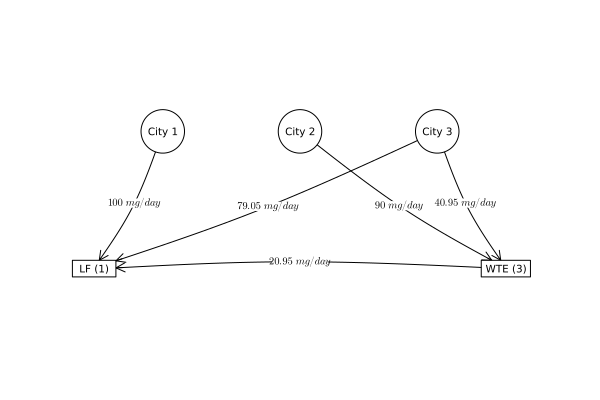

In [60]:
import Pkg; Pkg.add("GraphPlot")
import Pkg; Pkg.add("LaTeXStrings")
using GraphPlot
using LaTeXStrings
using Printf

# Node names
names = ["City 1", "City 2", "City 3", "LF (1)", "WTE (3)"]

# Adjacency matrix (binary: 1 = connection, 0 = no connection)
A = [
    0 0 0 1 0;  # City 1 to LF
    0 0 0 0 1;  # City 2 to WTE
    0 0 0 1 1;  # City 3 to LF and WTE
    0 0 0 0 0;  #  No residuals
    0 0 0 1 0   # WTE to LF
]

# Edge labels with LaTeX formatting
edge_labels = Dict(
    (1, 4) => L"100\ {mg/day}",
    (2, 5) => L"90\ {mg/day}",
    (3, 4) => L"79.05\ {mg/day}",
    (3, 5) => L"40.95\ {mg/day}",
    (5, 4) => L"20.95\ {mg/day}"
)

# Node positions (adjust for better visualization)
xpos = [-1, 0, 1, -1.5, 1.5]
ypos = [2, 2, 2, 1, 1]

# Node shapes
shapes = [:ellipse, :ellipse, :ellipse, :rect, :rect]

# Plotting the graph
p = graphplot(
    A,
    names=names,
    edgelabel=edge_labels,
    markersize=0.15,
    markershapes=shapes,
    markercolor=:white,
    x=xpos,
    y=ypos
)

display(p)


## References

List any external references consulted, including classmates.
Consulted online sources to create code for diagram 